In [2]:
import numpy as np
import tensorflow as tf
from neuralode.odeint import odeint
from neuralode.utils import _flatten
import matplotlib
import matplotlib.pyplot as plt
tf.enable_eager_execution()
tfe = tf.contrib.eager
from IPython.display import clear_output


/Users/taraskhakhulin/Library/Python/3.6/lib/python/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [87]:
data_size = 130
batch_time = 5
batch_size = 10

true_y0 = np.array([[0.5, 0.3]], dtype=np.float32)
true_A = np.array([[-0.1, -1.], [1., -0.1]],  dtype=np.float32)
t = tf.linspace(-1.4, 1.4, data_size)

class Model(tf.keras.Model):
    def call(self, y, t):
        return tf.matmul(y, true_A)

f = Model()
true_y = tf.contrib.integrate.odeint(lambda y0, t: f(y0, t), true_y0, t)


In [88]:
def create_batch():
    min_delta_time = 1.0
    max_delta_time = 5.0
    max_points_num = 32
    t_max = 6.29 * 3
    n_points = 200
    n_steps = 1000
    index_np = np.arange(0, n_points, 1, dtype=np.int)
    index_np = np.hstack([index_np[:, None]])
    times_np = np.linspace(0, t_max, num=n_points)
    times_np = np.hstack([times_np[:, None]])

    t0 = np.random.uniform(0, t_max - max_delta_time)
    t1 = t0 + np.random.uniform(min_delta_time, max_delta_time)

    idx = sorted(np.random.permutation(index_np[(times_np > t0) & (times_np < t1)])[:max_points_num])
    true_y = tf.contrib.integrate.odeint(lambda y0, t: f(y0, t), true_y0, times_np.squeeze()).numpy()

    obs = true_y + np.random.randn(*true_y.shape) * 0.01

    obs_ = obs[idx]
    ts_ = times_np[idx]
    return tf.convert_to_tensor(obs_, dtype=tf.float32), tf.convert_to_tensor(ts_.squeeze(), dtype=tf.float32)

def plot_traj(obs=None, times=None, trajs=None, figsize=(16, 8), true_traj=None):
    plt.figure(figsize=figsize)
    print(obs[0].shape)
    print(times[0].shape)
    if obs is not None:
        if times is None:
            times = [None] * len(obs)
        for o, t in zip(obs, times):
            # o, t = to_np(o), to_np(t)
            for b_i in range(o.shape[1]):
                plt.scatter(o[:, b_i, 0], o[:, b_i, 1], c=t)

    if trajs is not None:
        for z in trajs:
            # z = to_np(z)
            plt.plot(z[:, 0, 0], z[:, 0, 1], lw=1.5)
    if true_traj is not None:
        plt.plot(true_traj[:,0, 0], true_traj[:,0, 1])

    plt.show()


In [89]:
f = Model()
# _, times = create_batch()
t = tf.linspace(-10., 10., data_size)

true_y = tf.contrib.integrate.odeint(lambda y0, t: f(y0, t), true_y0, t)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(50, input_shape=(2,), activation=tf.nn.relu),
    tf.keras.layers.Dense(2),
])

(32, 1, 2)
(32,)


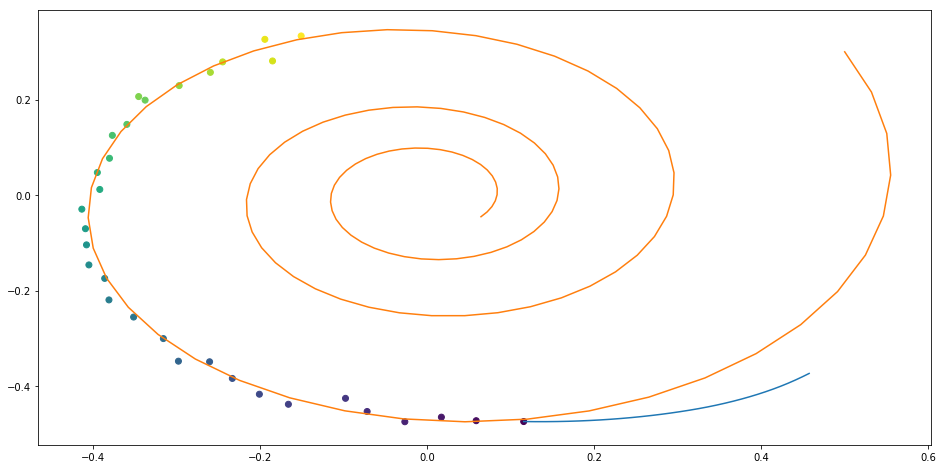

In [90]:
obs, time = create_batch()
# model = Model()
model_func = lambda *args, **kwargs: model(*args, **kwargs)
# true_y = tf.contrib.integrate.odeint(lambda y0, t: model_func(y0, t), true_y0, t)
# print(true_y.shape)

# print(model_func(obs[0], time))
pred_y = tf.contrib.integrate.odeint(lambda y0, t: model_func(y0, t), obs[0], time)
plot_traj([obs], [time], [pred_y], true_traj=true_y)


(130, 1, 2)
(130,)


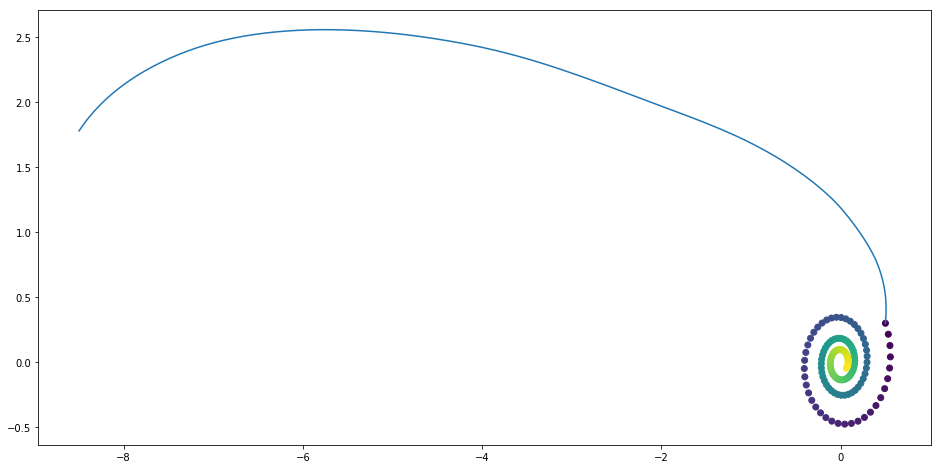

In [ ]:
lr = 1e-3
optimizer = tf.train.AdamOptimizer(lr)
niters = 10
plot_freq = 1
log_freq = 1
for i in range(1, niters + 1):
    batch_y0, batch_t = create_batch()
    with tf.GradientTape() as tape:
        pred_y = odeint(model_func, batch_y0[0], batch_t)
        
        loss = tf.reduce_mean(tf.abs(pred_y - batch_y0))
    grads = tape.gradient(loss, model.variables)
    grad_vars = zip(grads, model.variables)
    optimizer.apply_gradients(grad_vars)
    if i % log_freq == 0:
        pred_y = odeint(model_func, true_y0, t)
        loss = tf.reduce_mean(tf.abs(pred_y - true_y))
        print('Iter {} | Loss {}'.format(i, loss.numpy()))
    if i % plot_freq == 0:
        pred_y = odeint(model_func, true_y0, t)
        true_y_obs = tf.contrib.integrate.odeint(lambda y0, t: f(y0, t), true_y0, t).numpy()
        plot_traj([true_y_obs], [t], [pred_y])
        clear_output(wait=True)